# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


. [Correlations](#correlations)


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math



## Dataset Overview


The dataset used in this project is the **“Prediction of Sepsis”** dataset from Kaggle, which is a cleaned, tabular version of the PhysioNet Computing in Cardiology Challenge 2019 sepsis data. It contains **1,552,210 hourly time-step records** from roughly **40,336 ICU patients**, of whom "only" **2932 Patients** develop a sepsis at one point. This makes the dataset highly unbalanced. The dataset contains with **44 clinical features** per record (vital signs, laboratory values and demographics) and a binary label indicating whether the patient is septic at each given time. The goal of the dataset is to enable **early prediction of sepsis**, ideally several hours before the clinical diagnosis.  
Dataset source: https://www.kaggle.com/datasets/salikhussaini49/prediction-of-sepsis/data


[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [ ]:
import pandas as pd

# Load the data
df_raw = pd.read_csv('../data/Dataset.csv')

# Number of datapoints
num_datapoints = df_raw.shape[0]

# Number of features
num_features = df_raw.shape[1]

# Number of Patients
num_patients = df_raw['Patient_ID'].nunique()

#Number of Patients WITH Sepsis
num_patients_with_sepsis = df_raw.loc[df_raw['SepsisLabel'] == 1, 'Patient_ID'].nunique()


# Display these dataset characteristics
print(f"Number of data points: {num_datapoints}")
print(f"Number of features: {num_features}")
print(f"Number of patients: {num_patients}")
print(f"Number of patients with sepsis: {num_patients_with_sepsis}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
print(df_raw.head())



Number of data points: 1552210
Number of features: 44
Number of patients: 40336
Number of patients with sepsis: 2932
Example data:
   Unnamed: 0  Hour    HR  O2Sat  Temp    SBP   MAP   DBP  Resp  EtCO2  ...  \
0           0     0   NaN    NaN   NaN    NaN   NaN   NaN   NaN    NaN  ...   
1           1     1  65.0  100.0   NaN    NaN  72.0   NaN  16.5    NaN  ...   
2           2     2  78.0  100.0   NaN    NaN  42.5   NaN   NaN    NaN  ...   
3           3     3  73.0  100.0   NaN    NaN   NaN   NaN  17.0    NaN  ...   
4           4     4  70.0  100.0   NaN  129.0  74.0  69.0  14.0    NaN  ...   

   Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0         NaN        NaN  68.54       0    NaN    NaN        -0.02       1   
1         NaN        NaN  68.54       0    NaN    NaN        -0.02       2   
2         NaN        NaN  68.54       0    NaN    NaN        -0.02       3   
3         NaN        NaN  68.54       0    NaN    NaN        -0.02       4   
4   

## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]

Handling missing values is a key challenge in this dataset and reflects real-world ICU scenarios.

The original PhysioNet sepsis data are highly sparse (overall density of entries is around 20% for vital signs and laboratory values). This means that many measurements are missing at different time steps.

As there are many possible ways to impute data and deal with missingness, I decided to follow the approach used by the winning team of the PhysioNet Challenge: missing values within each patient’s ICU stay are handled using **forward filling**. At each hour, any missing measurement is replaced by the most recently observed value for that patient. If no previous value exists (e.g. at the very beginning of a stay), the entry is **left as NaN** and handled directly by the downstream model.


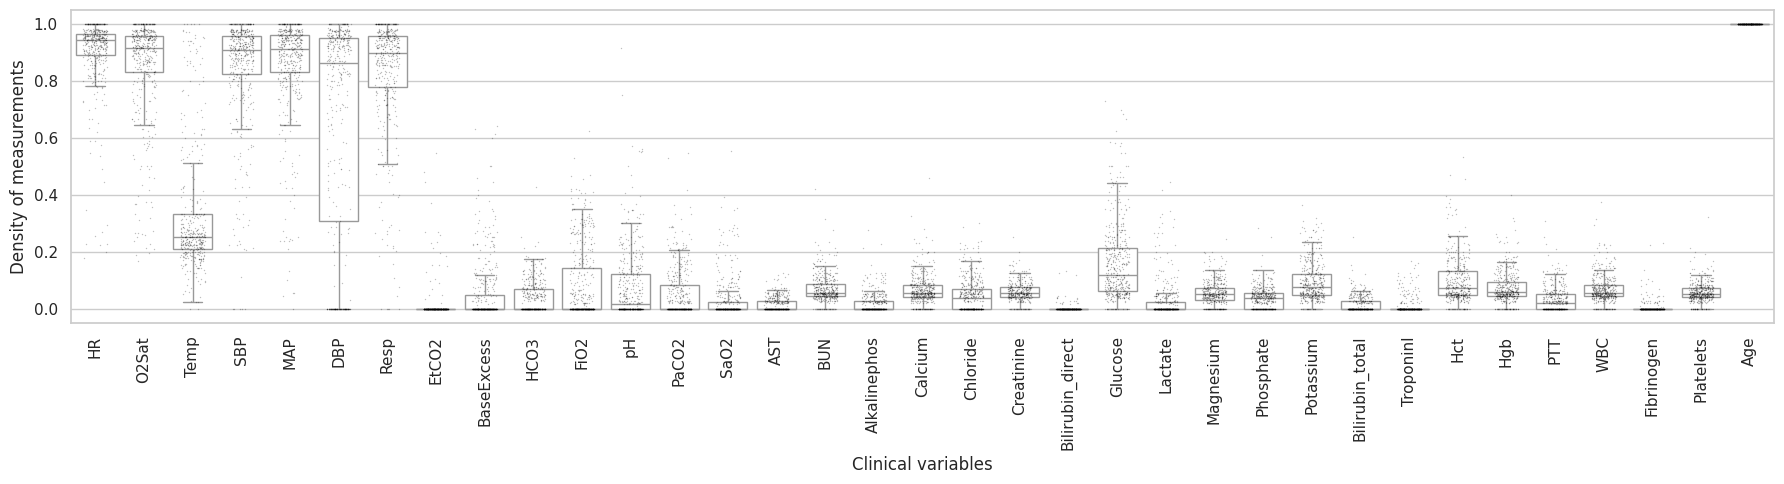

Densities of vital sign (rows 1-8) and laboratory value (rows 9-34) entries (fraction of non-empty entries) in the given dataset


In [17]:
sns.set(style="whitegrid")

# ------------------------------------------------
# 1) Desired order of clinical variables
#     (adapt to exact column names in your df_raw)
# ------------------------------------------------
desired_order = [
    "HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp", "EtCO2",
    "BaseExcess", "HCO3", "FiO2", "pH", "PaCO2", "SaO2",
    "AST", "BUN", "Alkalinephos", "Calcium", "Chloride",
    "Creatinine", "Bilirubin_direct", "Glucose", "Lactate",
    "Magnesium", "Phosphate", "Potassium", "Bilirubin_total",
    "TroponinI", "Hct", "Hgb", "PTT", "WBC", "Fibrinogen",
    "Platelets", "Age"
]

# keep only variables that actually exist in your dataframe
clinical_cols = [c for c in desired_order if c in df_raw.columns]

# ------------------------------------------------
# 2) Per-patient measurement density (0–1)
# ------------------------------------------------
densities = (
    df_raw
    .groupby("Patient_ID")[clinical_cols]
    .apply(lambda g: g.notna().mean())
)

dens_long = (
    densities
    .reset_index()
    .melt(
        id_vars="Patient_ID",
        var_name="Clinical variable",
        value_name="Density"
    )
)

# enforce the desired plotting order
dens_long["Clinical variable"] = pd.Categorical(
    dens_long["Clinical variable"],
    categories=clinical_cols,
    ordered=True
)

# optional: subsample for scatter
max_points = 15000
if len(dens_long) > max_points:
    dens_long = dens_long.sample(max_points, random_state=0)

# ------------------------------------------------
# 3) Plot
# ------------------------------------------------
plt.figure(figsize=(18, 5))

sns.boxplot(
    x="Clinical variable",
    y="Density",
    data=dens_long,
    color="white",
    fliersize=0
)

sns.stripplot(
    x="Clinical variable",
    y="Density",
    data=dens_long,
    jitter=0.25,
    size=1,
    alpha=0.25,
    color="black"
)

plt.ylim(-0.05, 1.05)
plt.xlabel("Clinical variables")
plt.ylabel("Density of measurements")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print ("Densities of vital sign (rows 1-8) and laboratory value (rows 9-34) entries (fraction of non-empty entries) in the given dataset")


In [ ]:
# Handling missing values
# Example: Replacing NaN values with the mean value of the column
# df.fillna(df.mean(), inplace=True)

# Your code for handling missing values goes here 

##### Please Note: The code for handling missing values is NOT model-agnostic therefore th code is found in chapter 2 and 3  


## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


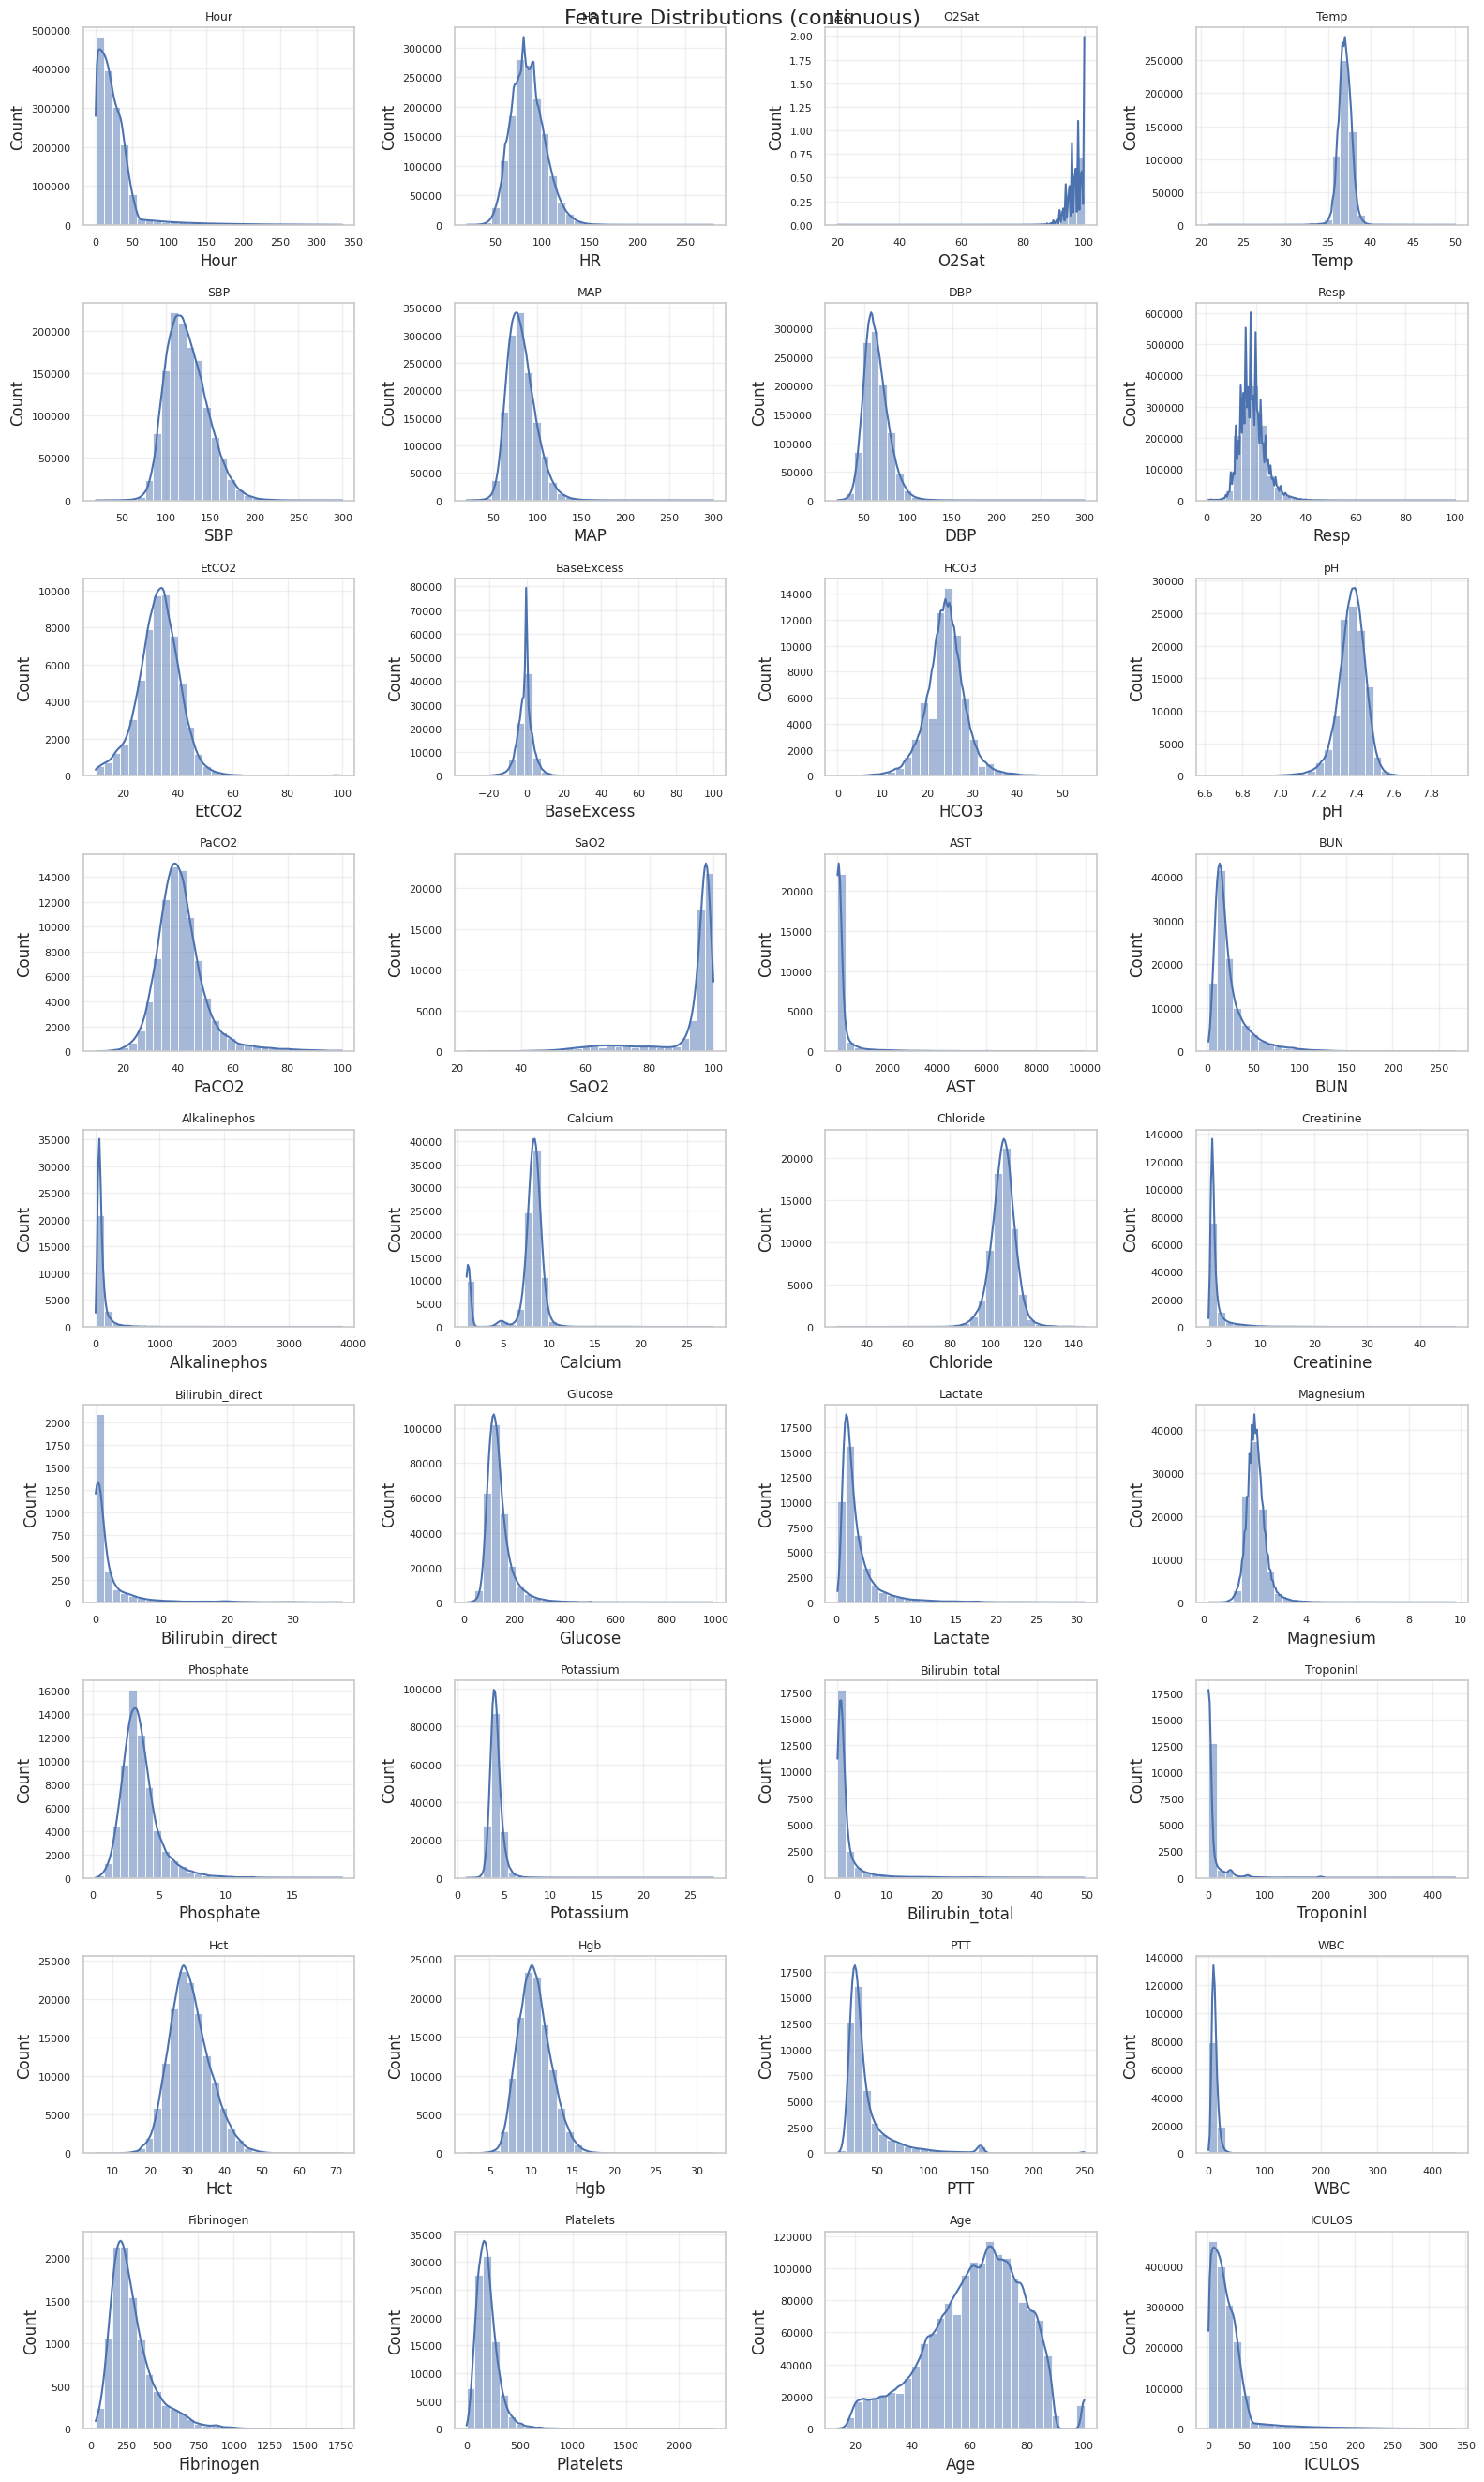

/tmp/ipykernel_7263/663656243.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "1"])
/tmp/ipykernel_7263/663656243.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "1"])


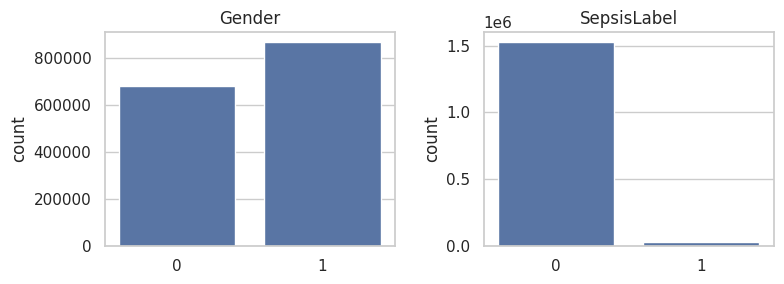

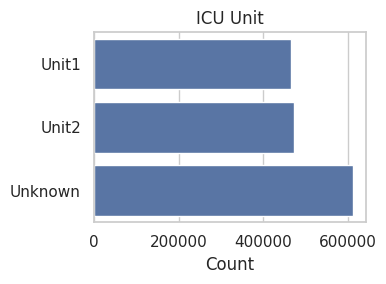

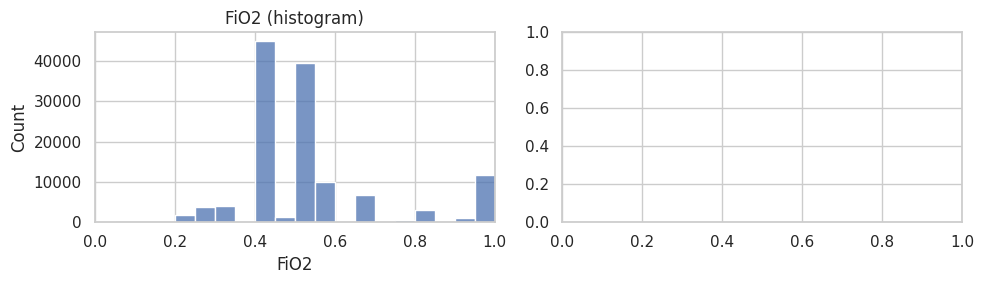

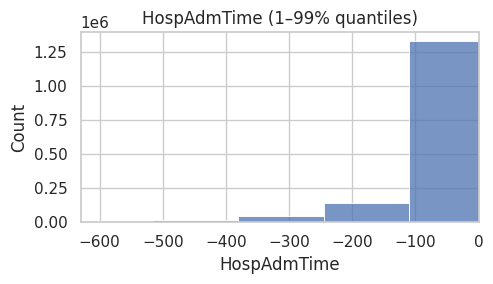

In [10]:


sns.set(style="whitegrid")

# -------------------------------------------------------
# 0) OPTIONAL: create combined ICU unit variable
# -------------------------------------------------------
if {"Unit1", "Unit2"}.issubset(df_raw.columns):
    df_raw["ICU_unit"] = np.where(
        df_raw["Unit1"] == 1, "Unit1",
        np.where(df_raw["Unit2"] == 1, "Unit2", "Unknown")
    )

# -------------------------------------------------------
# 1) Continuous numeric features (big grid)
# -------------------------------------------------------
numeric_cols = df_raw.select_dtypes(include="number").columns

cols_to_exclude = [
    "Unnamed: 0", "Patient_ID",      # IDs / index
    "Gender", "SepsisLabel",         # binary
    "Unit1", "Unit2",                # encoded in ICU_unit
    "FiO2", "HospAdmTime"            # treated separately
]

cont_cols = [c for c in numeric_cols if c not in cols_to_exclude]

n_cols = 4
n_rows = math.ceil(len(cont_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.ravel()

for ax, col in zip(axes, cont_cols):
    sns.histplot(df_raw[col].dropna(), bins=30, kde=True, ax=ax)
    ax.set_title(col, fontsize=9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis="both", labelsize=8)

for ax in axes[len(cont_cols):]:
    ax.set_visible(False)

fig.suptitle("Feature Distributions (continuous)", fontsize=16)
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 2) Binary features (0/1): Gender, SepsisLabel
# -------------------------------------------------------
binary_cols = [c for c in ["Gender", "SepsisLabel"] if c in df_raw.columns]

if binary_cols:
    fig, axes = plt.subplots(1, len(binary_cols), figsize=(4*len(binary_cols), 3))
    if len(binary_cols) == 1:
        axes = [axes]

    for ax, col in zip(axes, binary_cols):
        sns.countplot(x=col, data=df_raw, ax=ax)
        ax.set_title(col)
        ax.set_xlabel("")
        ax.set_xticklabels(["0", "1"])

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------
# 3) ICU unit (Unit1 vs Unit2)
# -------------------------------------------------------
if "ICU_unit" in df_raw.columns:
    plt.figure(figsize=(4, 3))
    sns.countplot(y="ICU_unit", data=df_raw, order=["Unit1", "Unit2", "Unknown"])
    plt.title("ICU Unit")
    plt.xlabel("Count")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------
# 4) FiO2 distribution (values between 0 and 1)
# -------------------------------------------------------
if "FiO2" in df_raw.columns:
    fio2 = df_raw["FiO2"].dropna()

    # bar plot of exact values (often more meaningful for FiO2)
    fio2_counts = fio2.value_counts().sort_index()

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # histogram, zoomed to [0, 1]
    sns.histplot(fio2, binrange=(0, 1), bins=20, ax=axes[0])
    axes[0].set_title("FiO2 (histogram)")
    axes[0].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------
# 5) HospAdmTime (trimmed to central 98% for readability)
# -------------------------------------------------------
if "HospAdmTime" in df_raw.columns:
    data = df_raw["HospAdmTime"].dropna()
    lo, hi = data.quantile([0.01, 0.99])  # remove extreme outliers

    plt.figure(figsize=(5, 3))
    sns.histplot(data, bins=40)
    plt.title("HospAdmTime (1–99% quantiles)")
    plt.xlim(lo, hi)
    plt.tight_layout()
    plt.show()


## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]

Result= Heavy imbalance (way more healthy patients than patients with sepsis)

Number of patients: 40336
Number of patients with sepsis: 2932


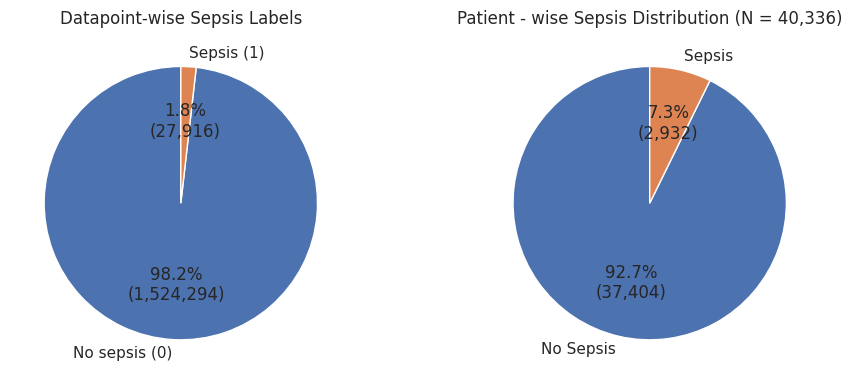

In [ ]:
def make_autopct(values):
    # returns a function for autopct that shows pct and absolute count
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct/100 * total))
        return f"{pct:.1f}%\n({count:,})"
    return my_autopct

# --- 1) Point-wise class imbalance (all rows) ---
sepsis_counts = df_raw["SepsisLabel"].value_counts().sort_index()
sizes_point = [sepsis_counts.get(0, 0), sepsis_counts.get(1, 0)]
labels_point = ["No sepsis (0)", "Sepsis (1)"]

# --- 2) Patient-level: ever vs never sepsis ---
patient_sepsis = df_raw.groupby("Patient_ID")["SepsisLabel"].max()

n_patients = patient_sepsis.shape[0]
n_sepsis_patients = (patient_sepsis == 1).sum()
n_no_sepsis_patients = (patient_sepsis == 0).sum()


sizes_pat = [n_no_sepsis_patients, n_sepsis_patients]
labels_pat = ["No Sepsis", "Sepsis"]

# --- Plot the two pie charts side by side ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Point-wise labels
axes[0].pie(
    sizes_point,
    labels=labels_point,
    autopct=make_autopct(sizes_point),
    startangle=90
)
axes[0].set_title("Datapoint-wise Sepsis Labels")

# Patient-level labels
axes[1].pie(
    sizes_pat,
    labels=labels_pat,
    autopct=make_autopct(sizes_pat),
    startangle=90
)
axes[1].set_title(f"Patient - wise Sepsis Distribution (N = {n_patients:,})")

plt.tight_layout()
plt.show()


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]

Fig 1: Pearson correlation heatmap of all clinical variables and the sepsis label. No notable correlations apart from obvious (more or less redundant) e.g. MAP/SBP/DBP or Billirubin_direct/total or Hgb/Hct

Fig 2: 
Pearson correlations between each feature and the sepsis label. All absolute correlations are small (0.06 or less), however the dataset reflects clinical routine where the respiratory rate, heart rate and temperature as parameters being easily measured play a key role in sepsis screening scores like qSOFA and SIRS

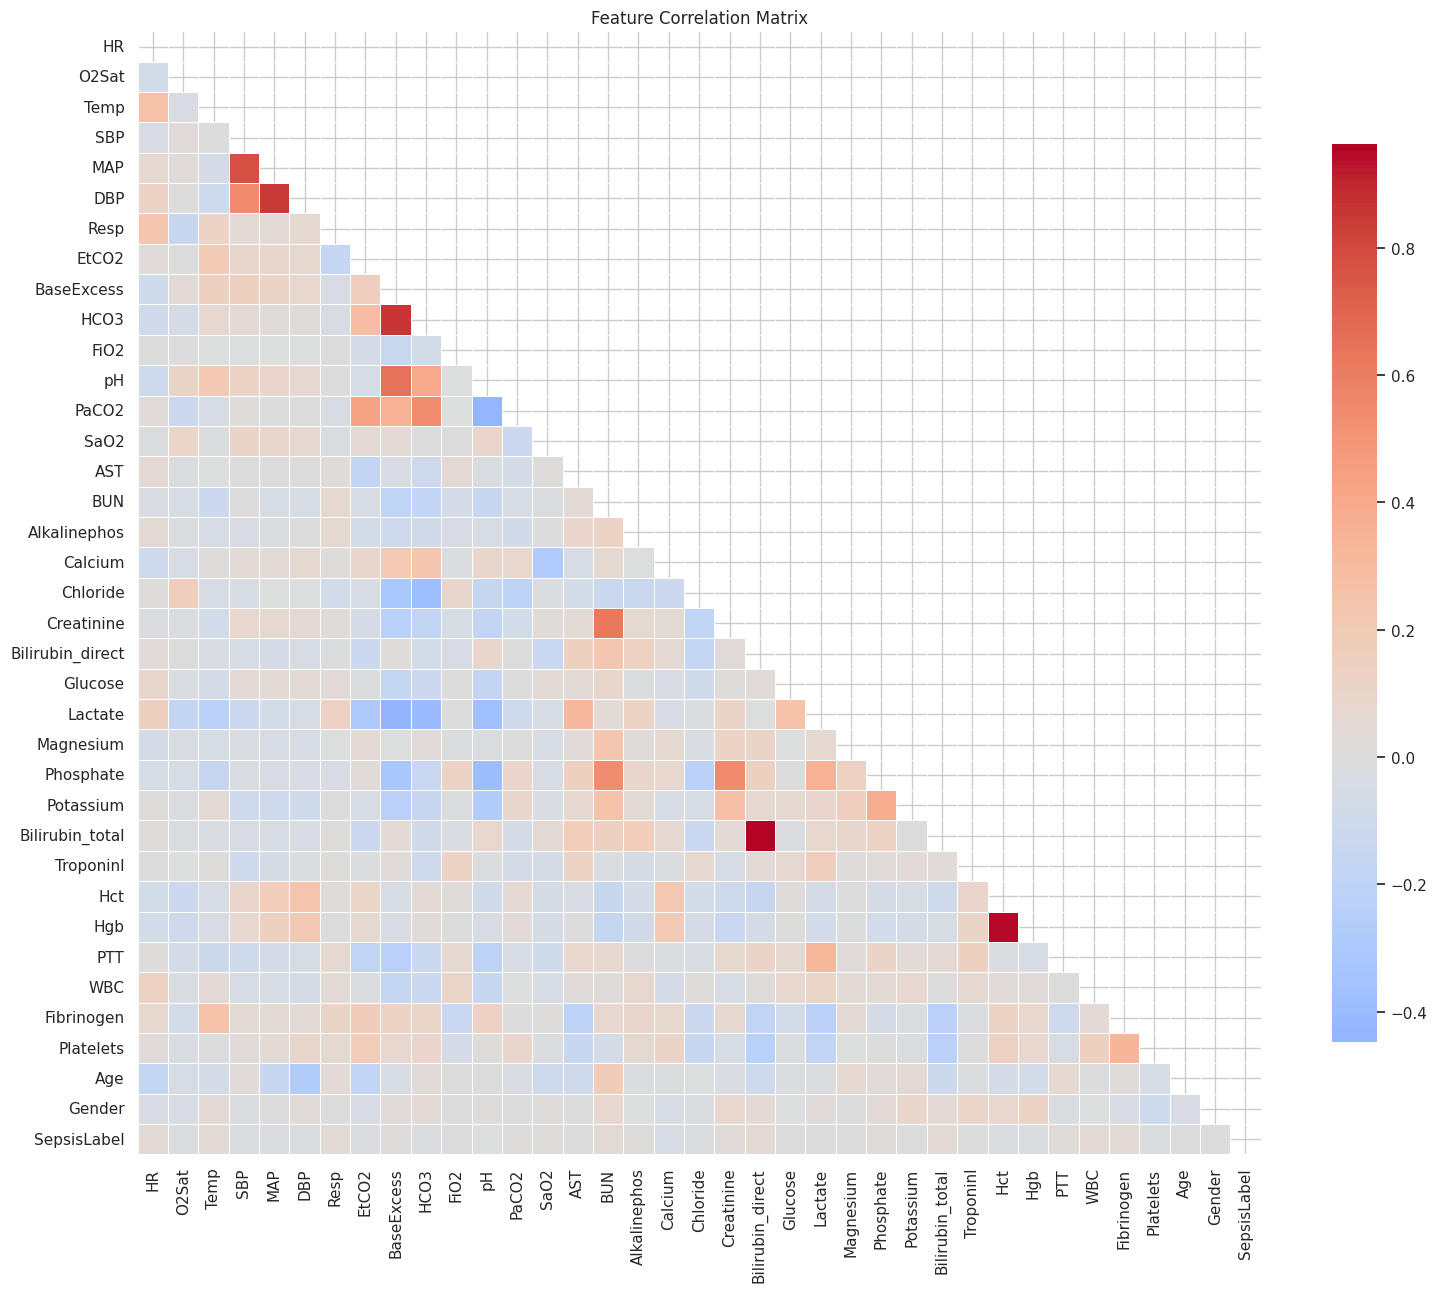

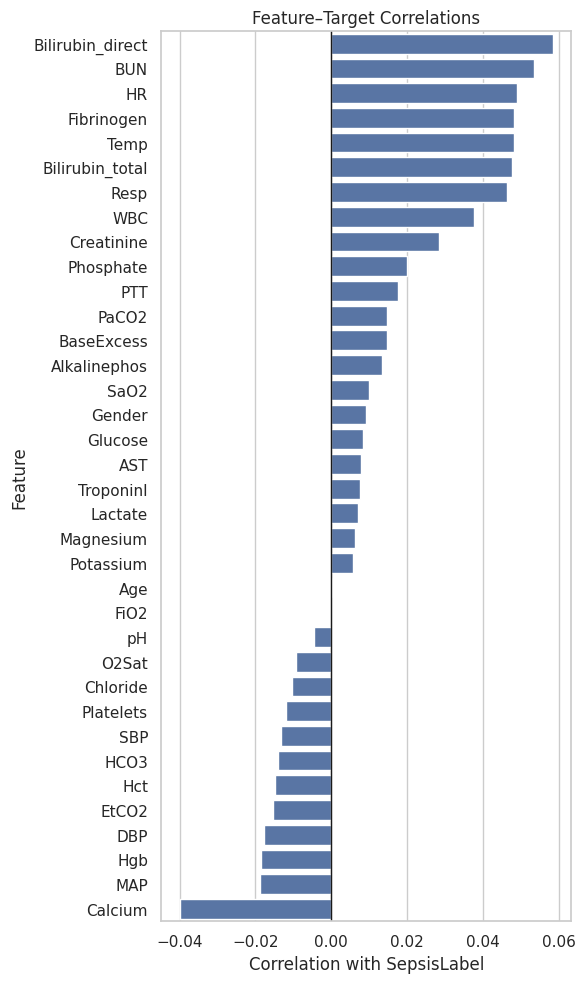

In [ ]:
# -----------------------------
# 1) Select numeric features
# -----------------------------
num_cols = df_raw.select_dtypes(include="number").columns

# drop IDs / time / duplicated encodings etc. (tweak as you like)
drop_cols = [
    "Unnamed: 0", "Patient_ID", "Hour", "ICULOS",
    "Unit1", "Unit2", "HospAdmTime"
]
cols = [c for c in num_cols if c not in drop_cols]

data_corr = df_raw[cols]

# -----------------------------
# 2) Full correlation matrix
# -----------------------------
corr = data_corr.corr(method="pearson")

# mask upper triangle to make it easier to read
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16, 13))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# -----------------------------
# 3) Correlation with SepsisLabel
# -----------------------------
if "SepsisLabel" in corr.columns:
    target_corr = (
        corr["SepsisLabel"]
        .drop("SepsisLabel")
        .sort_values(ascending=False)
    )

    plt.figure(figsize=(6, 10))
    sns.barplot(
        x=target_corr.values,
        y=target_corr.index,
        orient="h"
    )
    plt.axvline(0, color="k", linewidth=1)
    plt.xlabel("Correlation with SepsisLabel")
    plt.ylabel("Feature")
    plt.title("Feature–Target Correlations")
    plt.tight_layout()
    plt.show()
